# Image Manipulations and Image Spaces

## Tutorial

In [458]:
import numpy as np
from PIL import Image

# Transform RGB array to Lab array
from skimage.color import rgb2lab, lab2rgb
# Transform RGB to HSV
from skimage.color import rgb2hsv, hsv2rgb

# Histogram equalization on the V channel
from skimage.exposure import equalize_hist

import os
from matplotlib import pyplot as plt
import ipyplot
import pandas as pd

# Part 1

## Utils

In [459]:
def image_to_array(image : Image) -> np.array:
    return np.array(image, dtype=float)

def array_to_image(arr : np.ndarray) -> Image:
    return Image.fromarray(arr.astype(np.uint8))

def concat_vertical(size, *images):
    # Resize all images to have the same width while maintaining aspect ratio
    resized_images = [
        img.resize(size, Image.LANCZOS)
        for img in images
    ]
    
    # Calculate the total height after resizing
    total_height = sum(img.height for img in resized_images)
    
    # Create a blank canvas for the stacked images
    dst = Image.new('RGB', (size[0], total_height))

    # Paste images one below the other
    y_offset = 0
    for img in resized_images:
        dst.paste(img, (0, y_offset))
        y_offset += img.height

    return dst

def concat_horizontal(*images):
    size = images[0].height
    # Calculate the total width after resizing
    total_width = sum(image.width for image in images)
    
    # Create a blank canvas for the concatenated images
    dst = Image.new('RGB', (total_width, size))

    # Paste images side by side
    x_offset = 0
    for img in images:
        dst.paste(img, (x_offset, 0))
        x_offset += img.width

    return dst


params = [0, .2, .4, .6, .8, 1]
concat_horizontal(*(array_to_image(hungry_blue(sample_array, param)) for param in params))

def grid(func, params, images = sample_images, size = 150):    
    dst = Image.new('RGB', (size * (len(params)+1), size*len(images)))

    y_offset = 0
    for i, img in enumerate(images):
        dst.paste(img, (i*size, 0))
        for j, param in enumerate(params):
            dst.paste(func(img, param), (i*size, (j+1)*size))

    return dst

In [460]:
sample_images = [
    Image.open('dataset/1/4.1.01.tiff').resize((150,150)).convert('RGB'),
    Image.open('dataset/1/4.1.03.tiff').resize((150,150)).convert('RGB'),
    Image.open('dataset/2/241048.jpg').resize((150,150)).convert('RGB'),
    Image.open('dataset/2/304034.jpg').resize((150,150)).convert('RGB'),
    Image.open('dataset/3/s1.png').resize((150,150)).convert('RGB')
]

## Metric Calculation Functions

### Compute Power

In [461]:
def compute_power(image_array):
    # Constants
    gamma = 0.7755
    w_0 = 1.48169521e-6
    w_R = 2.13636845e-7
    w_G = 1.77746706e-7
    w_B = 2.14348309e-7

    # Normalize pixel values to rang[0,1]
    image_array = image_array/255.0

    # Extract R,G,B channels
    R = image_array[:,:,0]
    G = image_array[:,:,1]
    B = image_array[:,:,2]

    # Compute pixel-wise power consumption
    P_pixel = w_R*(R**gamma) + w_G * (G ** gamma) + w_B * (B ** gamma)

    P_image = w_0 + np.sum(P_pixel)

    return P_image
#########################################
# Load the image
image_path = "4.1.06.tiff"  
image = Image.open(image_path)
image_array = np.array(image)

# Compute power consumption
power_consumption = compute_power(image_array)

# Display the result
print(f"Power consumption for the image: {power_consumption:.10f}")

Power consumption for the image: 0.0235280153


In [462]:
def compute_power_saved(original, distorted, func = compute_power):
    o = func(original)
    d = func(distorted)

    return (o-d)/o

### Compute Distortion

In [463]:
def compute_distortion(original_image, transformed_image):
    # Convert both images to L*a*b* space
    lab_original = rgb2lab(original_image)
    lab_transformed = rgb2lab(transformed_image)
    
    # Compute the Euclidean distance for each pixel
    pixel_distances = np.sqrt(
        (lab_original[:, :, 0] - lab_transformed[:, :, 0]) ** 2 +
        (lab_original[:, :, 1] - lab_transformed[:, :, 1]) ** 2 +
        (lab_original[:, :, 2] - lab_transformed[:, :, 2]) ** 2
    )
    
    # Sum all pixel distances to calculate total distortion
    epsilon = np.sum(pixel_distances)
    
    return epsilon

In [464]:
# Function to compute percentage distortion
def compute_percentage_distortion(image, distorted):
    
    distortion = compute_distortion(image/255, distorted/255)
    
    # Extract image dimensions
    height, width, _ = image.shape
    
    # Maximum possible Euclidean distance in Lab space
    L_max = 100.0
    a_max = 255.0
    b_max = 255.0
    max_distance_per_pixel = np.sqrt(L_max**2 + a_max**2 + b_max**2)
    
    # Total maximum possible distortion
    max_possible_distortion = max_distance_per_pixel * height * width
    
    # Calculate percentage distortion
    percentage_distortion = (distortion / max_possible_distortion)
    
    return percentage_distortion


# Visualization

In [465]:

def grid(func, params, images = sample_images, size = 150):    
    dst = Image.new('RGB', (size * (len(params)+1), size*len(images)))


    for j, img in enumerate(images):
        dst.paste(img, (0, j*size))

        power = [0]
        dist = [0]
        for i, param in enumerate(params):
            distorted = array_to_image(func(image_to_array(img), param))
            dst.paste(distorted, ((i+1)*size, j*size))
            dist.append(compute_percentage_distortion(image_to_array(img), image_to_array(distorted)))
            power.append(compute_power_saved(image_to_array(img), image_to_array(distorted)))

        plt.plot(dist,power, marker='o', label=f'Pic {j}')

    plt.xlabel('Distortion %')
    plt.ylabel('Power saving %')
    plt.legend()
    plt.grid()

    return dst

## Transformations

In [466]:
transformations = {}

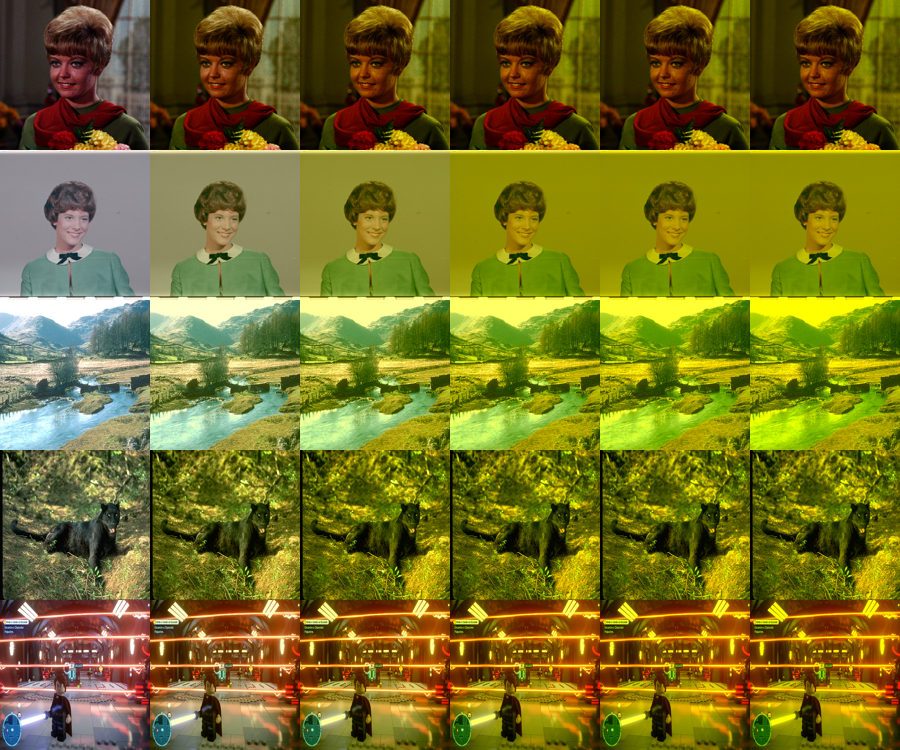

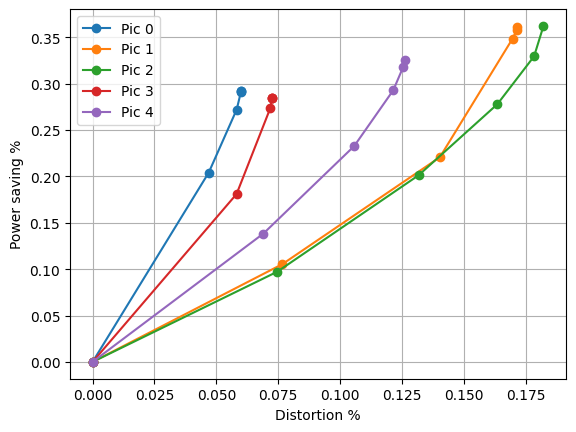

In [467]:
def hungry_blue(arr_in : np.ndarray, reduction : float) -> np.ndarray:
    arr = arr_in.copy()
    arr[:,:,2] = np.clip(arr[:,:,2] - 255*reduction, a_min = 0, a_max = np.inf)
    return arr

transformations['hungry_blue'] = (hungry_blue, [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], compute_power)

grid(hungry_blue, [.2, .4, .6, .8, 1])

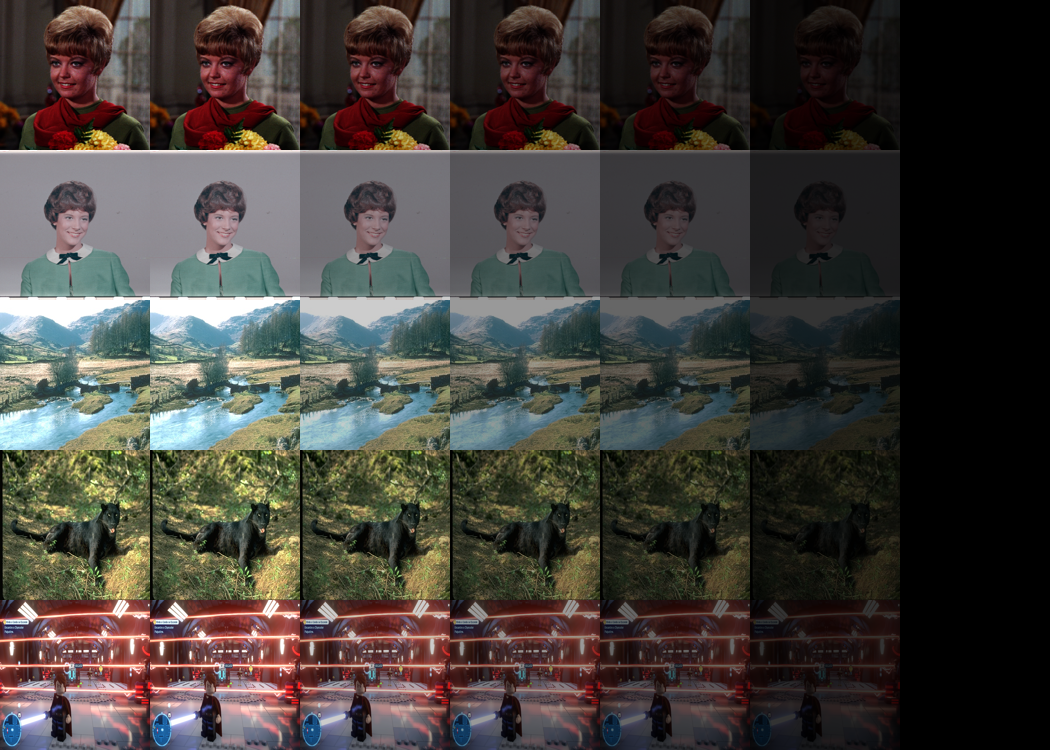

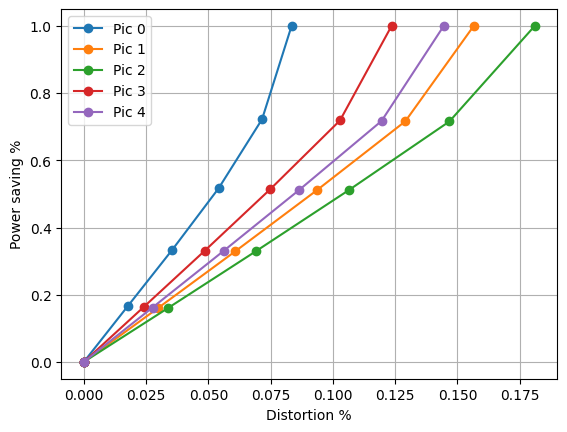

In [468]:
def dimming(arr_in : np.ndarray, reduction : float) -> np.ndarray:
    arr = arr_in.copy()
    arr = arr*reduction
    return arr

transformations['dimming'] = (dimming, [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], compute_power)


grid(dimming, [1, .8, .6, .4, .2, 0])

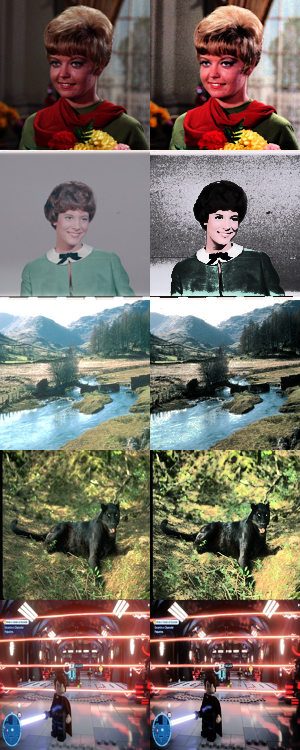

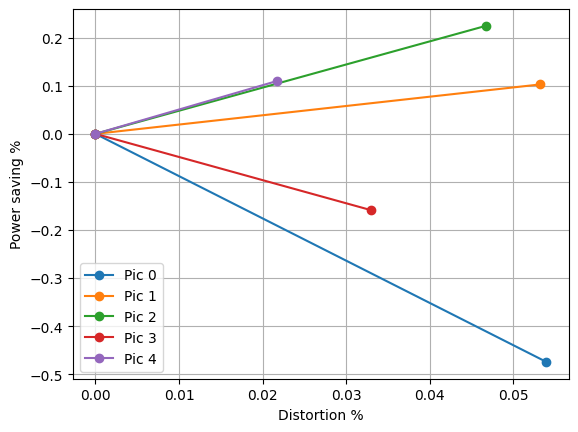

In [469]:
def hist_eq(arr_in : np.ndarray):
    image_array_hsv = rgb2hsv(arr_in/255)
    image_array_hsv[:, :, 2] = equalize_hist(image_array_hsv[:, :, 2])

    return hsv2rgb(image_array_hsv)*255

transformations['hist_equalization'] = (hist_eq, None, compute_power)

def hist_eq_param(img, x):
    return hist_eq(img)

grid(hist_eq_param, [None])

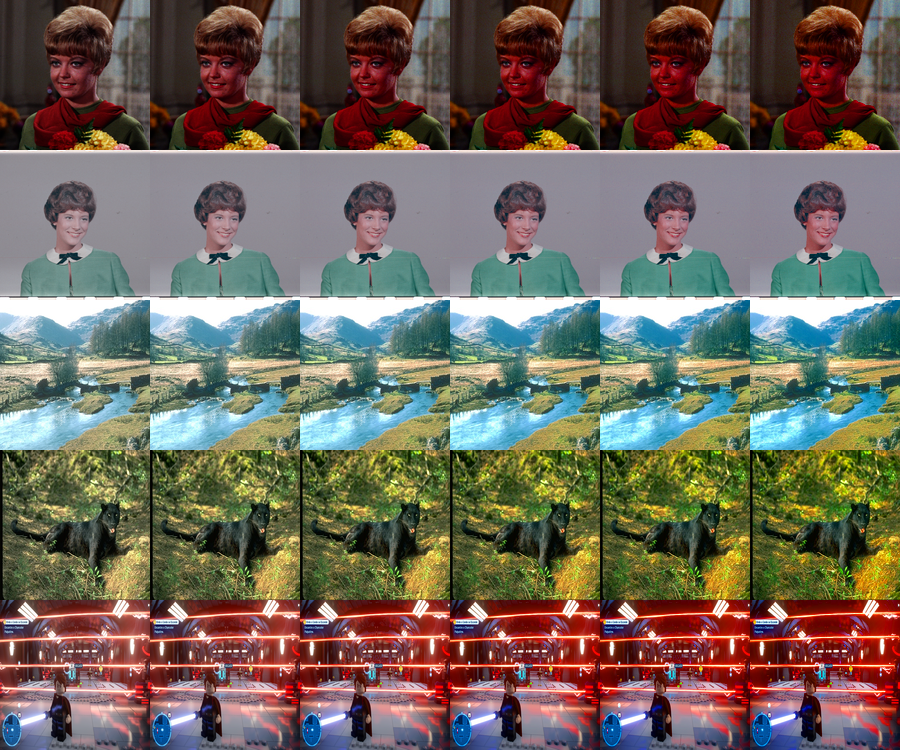

In [470]:
def dimm_saturation(arr_in : np.ndarray, increase):
    image_array_hsv = rgb2hsv(arr_in/255)
    image_array_hsv[:, :, 1] = np.clip(image_array_hsv[:, :, 1] * increase, a_min=0, a_max = 1)

    return hsv2rgb(image_array_hsv)*255

transformations['dimm_saturation'] = (dimm_saturation, [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2], compute_power)

dimm_saturation_array = dimm_saturation(sample_array, 1.5)
concat_horizontal(sample_image, array_to_image(dimm_saturation_array))

params = [1, 1.2, 1.4, 1.6, 1.8, 2]
concat_horizontal(*(array_to_image(dimm_saturation(sample_array, param)) for param in params))

## DVS

In [471]:
P1 = 4.251e-5  
P2 = -3.029e-4 
P3 = 3.024e-5  
DEFAULT_VDD = 15  

def compute_pixel_current(drgb: np.ndarray, vdd: float = DEFAULT_VDD) -> np.ndarray:
    return (P1 * vdd * drgb) / 255 + (P2 * drgb) / 255 + P3
    

In [472]:
def compute_panel_power(i_cell: np.ndarray, vdd: float = DEFAULT_VDD) -> float:
    return vdd * np.sum(i_cell)


In [473]:
from typing import Tuple

def displayed_image(
        i_cell: np.ndarray,
        vdd: float,
        p1: float = 4.251e-5,
        p2: float = -3.029e-4,
        p3: float = 3.024e-5,
        orig_vdd: float = 15,
        ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Display an image on the OLED display taking into account the effect of DVS.

    :param i_cell: An array of the currents drawn by each pixel of the display.
    :param vdd: The new voltage of the display.
    """
    i_cell_max = (p1 * vdd * 1) + (p2 * 1) + p3
    image_rgb_max = (i_cell_max - p3) / (p1 * orig_vdd + p2) * 255
    out = np.round((i_cell - p3) / (p1 * orig_vdd + p2) * 255)
    original_image = out.copy()

    # Clip the values exceeding `i_cell_max` to `image_rgb_max`
    out[i_cell > i_cell_max] = image_rgb_max

    return original_image.astype(np.uint8), out.astype(np.uint8)

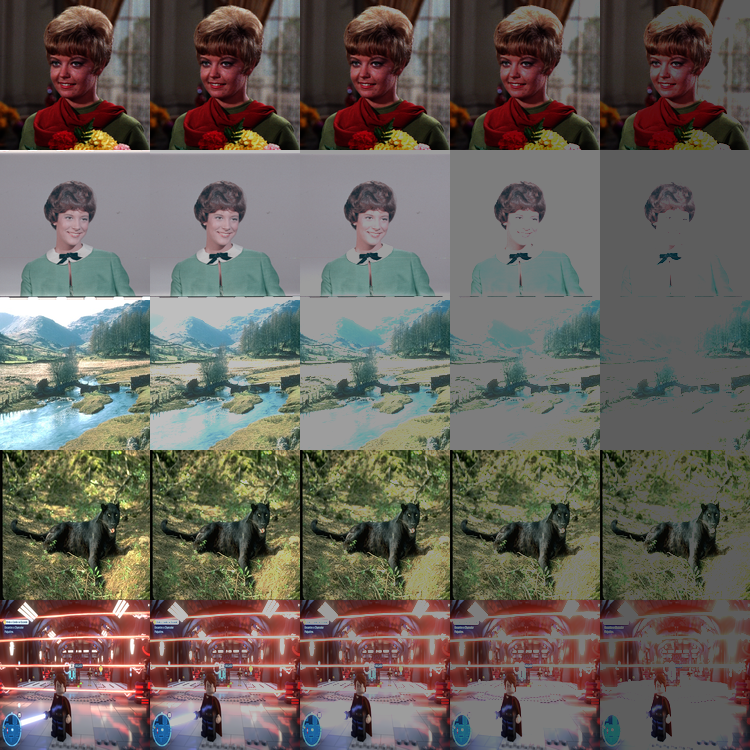

In [474]:
def dvs(arr_in : np.ndarray, voltage):
    return displayed_image(compute_pixel_current(arr_in), voltage)[1]

#transformations = {}
transformations['dvs'] = (dvs, [10, 11, 12, 13, 15], compute_panel_power)

params = [15, 13, 12, 11, 10]
concat_horizontal(*(array_to_image(dvs(sample_array, param)) for param in params))

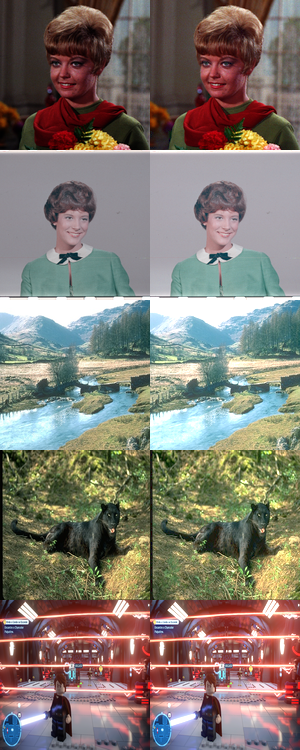

In [475]:
def brightness_dvs(arr_in : np.ndarray, voltage, brightness):
    image_array_hsv = rgb2hsv(arr_in/255)
    image_array_hsv[:, :, 2] += brightness
    arr_conv = hsv2rgb(image_array_hsv)*255

    return displayed_image(compute_pixel_current(arr_conv), voltage)[1]

#transformations['dvs'] = (dimm_saturation, [3, 6, 9, 12, 15], compute_panel_power)

brightness_dvs_array = brightness_dvs(sample_array, 15, .1)
concat_horizontal(sample_image, array_to_image(brightness_dvs_array))

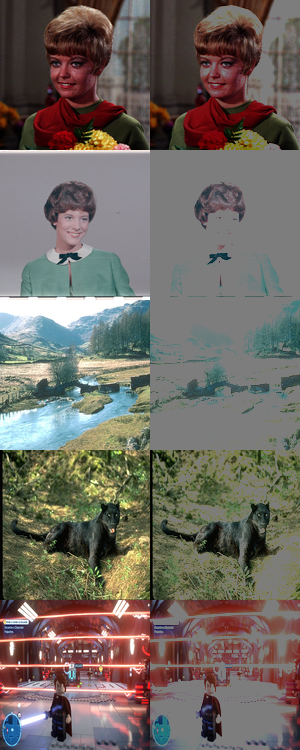

In [476]:
def contrast_dvs(arr_in : np.ndarray, voltage, brightness):
    image_array_hsv = rgb2hsv(arr_in/255)
    image_array_hsv[:, :, 2] *= brightness
    arr_conv = hsv2rgb(image_array_hsv)*255

    return displayed_image(compute_pixel_current(arr_conv), voltage)[1]

#transformations['dvs'] = (dimm_saturation, [3, 6, 9, 12, 15], compute_panel_power)

contrast_dvs_array = contrast_dvs(sample_array, 11, 1.2)
concat_horizontal(sample_image, array_to_image(contrast_dvs_array))

# Data Manipulation

In [477]:
def get_metrics(dataset, function, parameters, power_func = compute_power):
    powers = []
    distortions = []

    for i, image in enumerate(dataset):
        if i%(len(dataset)//10) == 0:
            print('.', end='')
        
        distorted_image = function(image, parameters) if not parameters is None else function(image)

        power_saved = compute_power_saved(image, distorted_image, power_func)
        powers.append(power_saved)

        distortion = compute_percentage_distortion(image, distorted_image)
        distortions.append(distortion)

    return sum(powers)/len(powers), max(powers), min(powers), sum(distortions)/len(distortions), max(distortions), min(distortions)

In [478]:
datasets = {
    'Dataset 1' : [image_to_array(Image.open('dataset/1/' + path)) for path in os.listdir('dataset/1/')],
    #'Dataset 2' : [image_to_array(Image.open('dataset/2/' + path)) for path in os.listdir('dataset/2/')],
    #'Dataset 3' : [image_to_array(Image.open('dataset/3/' + path).convert('RGB)) for path in os.listdir('dataset/3/')],
}

stats = []

for dataset_name in datasets.keys():
    print(dataset_name)
    sdf = datasets[dataset_name]
    for name in transformations.keys():
        print(name)
        function, parameters, power_func = transformations[name]

        if not parameters is None:
            for parameter in parameters:
                print(parameter, end = '\t: ')
                stats.append([dataset_name, name, str(parameter), *get_metrics(sdf, function, parameter, power_func)])
                print(' Done')
        else:
            stats.append([dataset_name, name, str(parameter), *get_metrics(sdf, function, None)])
        

Dataset 1
hungry_blue
0	: .............. Done
0.1	: .............. Done
0.2	: .............. Done
0.3	: .............. Done
0.4	: .............. Done
0.5	: .............. Done
0.6	: .............. Done
0.7	: .............. Done
0.8	: .............. Done
0.9	: .............. Done
1	: .............. Done
dimming
0	: .............. Done
0.1	: .............. Done
0.2	: .............. Done
0.3	: .............. Done
0.4	: .............. Done
0.5	: .............. Done
0.6	: .............. Done
0.7	: .............. Done
0.8	: .............. Done
0.9	: .............. Done
1	: .............. Done
hist_equalization
..............dimm_saturation
1	: .............. Done
1.1	: .............. Done
1.2	: .............. Done
1.3	: .............. Done
1.4	: .............. Done
1.5	: .............. Done
1.6	: .............. Done
1.7	: .............. Done
1.8	: .............. Done
1.9	: .............. Done
2	: .............. Done
dvs
10	: .............. Done
11	: .............. Done
12	: .............. Do

In [479]:
df_stats = pd.DataFrame(columns = ['dt_name', 'type', 'parameter', 'p_avg', 'p_min', 'p_max', 'd_avg', 'd_min', 'd_max'], data=stats)

#df_stats.to_csv('metrics.csv')

In [480]:
df_stats

dt_name               type parameter     p_avg     p_min     p_max  \
0   Dataset 1        hungry_blue         0  0.000000  0.000000  0.000000   
1   Dataset 1        hungry_blue       0.1  0.071465  0.187243  0.039181   
2   Dataset 1        hungry_blue       0.2  0.132096  0.251884  0.079853   
3   Dataset 1        hungry_blue       0.3  0.182783  0.278533  0.122604   
4   Dataset 1        hungry_blue       0.4  0.222114  0.293855  0.166416   
5   Dataset 1        hungry_blue       0.5  0.254615  0.315116  0.211738   
6   Dataset 1        hungry_blue       0.6  0.283598  0.348788  0.230201   
7   Dataset 1        hungry_blue       0.7  0.303242  0.361585  0.235026   
8   Dataset 1        hungry_blue       0.8  0.317380  0.366276  0.237666   
9   Dataset 1        hungry_blue       0.9  0.323937  0.374739  0.238156   
10  Dataset 1        hungry_blue         1  0.324294  0.374793  0.238156   
11  Dataset 1            dimming         0  0.999945  0.999988  0.999804   
12  Dataset 1            dimming       0.1  0.832267  0.832303  0.832150   
13  Dataset 1            dimming       0.2  0.712916  0.712947  0.712816   
14  Dataset 1            dimming       0.3  0.606862  0.606889  0.606777   
15  Dataset 1            dimming       0.4  0.508614  0.508636  0.508543   
16  Dataset 1            dimming       0.5  0.415791  0.415809  0.415732   
17  Dataset 1            dimming       0.6  0.327073  0.327087  0.327027   
18  Dataset 1            dimming       0.7  0.241630  0.241640  0.241596   
19  Dataset 1            dimming       0.8  0.158894  0.158901  0.158872   
20  Dataset 1            dimming       0.9  0.078454  0.078457  0.078443   
21  Dataset 1            dimming         1  0.000000  0.000000  0.000000   
22  Dataset 1  hist_equalization         1  0.031161  0.277188 -1.328332   
23  Dataset 1    dimm_saturation         1  0.000000  0.000000  0.000000   
24  Dataset 1    dimm_saturation       1.1  0.021130  0.055591  0.003887   
25  Dataset 1    dimm_saturation       1.2  0.041933  0.113084  0.007775   
26  Dataset 1    dimm_saturation       1.3  0.061380  0.166823  0.011657   
27  Dataset 1    dimm_saturation       1.4  0.078324  0.209569  0.015540   
28  Dataset 1    dimm_saturation       1.5  0.092621  0.227542  0.019436   
29  Dataset 1    dimm_saturation       1.6  0.105322  0.235797  0.023348   
30  Dataset 1    dimm_saturation       1.7  0.116905  0.241565  0.027275   
31  Dataset 1    dimm_saturation       1.8  0.127440  0.246179  0.031222   
32  Dataset 1    dimm_saturation       1.9  0.137001  0.250007  0.035189   
33  Dataset 1    dimm_saturation         2  0.145785  0.258381  0.039179   
34  Dataset 1                dvs        10  0.347606  0.498631  0.054832   
35  Dataset 1                dvs        11  0.209169  0.341451  0.015204   
36  Dataset 1                dvs        12  0.102893  0.195507  0.002260   
37  Dataset 1                dvs        13  0.030930  0.064988  0.000383   
38  Dataset 1                dvs        15  0.000000  0.000000  0.000000   

           d_avg         d_min         d_max  
0   0.000000e+00  0.000000e+00  0.000000e+00  
1   3.524366e-02  4.053773e-02  2.332632e-02  
2   6.465737e-02  8.092834e-02  3.114776e-02  
3   8.743581e-02  1.171848e-01  3.419715e-02  
4   1.041655e-01  1.431426e-01  3.550925e-02  
5   1.162158e-01  1.721183e-01  3.595972e-02  
6   1.240756e-01  1.944914e-01  3.609587e-02  
7   1.282952e-01  2.083826e-01  3.611871e-02  
8   1.301845e-01  2.146374e-01  3.612370e-02  
9   1.306252e-01  2.154439e-01  3.612463e-02  
10  1.306427e-01  2.154439e-01  3.612466e-02  
11  1.634497e-01  2.089331e-01  4.522942e-02  
12  1.514432e-01  1.925959e-01  4.231517e-02  
13  1.326411e-01  1.669282e-01  3.894138e-02  
14  1.138667e-01  1.430086e-01  3.477624e-02  
15  9.588371e-02  1.204161e-01  3.005412e-02  
16  7.866629e-02  9.879149e-02  2.507560e-02  
17  6.208173e-02  7.795436e-02  2.002557e-02  
18  4.599421e-02  5.774931e-02  1.496657e-02  
19  3.032100e-02  3.80678

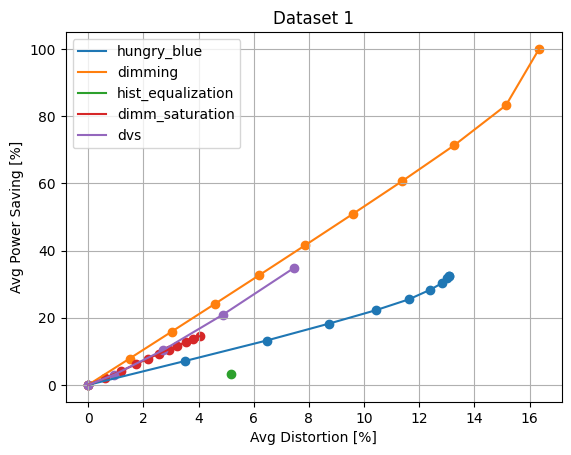

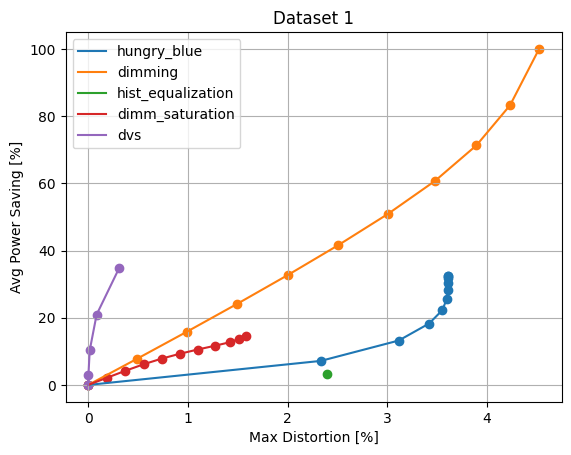

In [481]:
for dataset_name in df_stats['dt_name'].unique():
    df = df_stats[df_stats['dt_name'] == dataset_name]

    for metric_type in ['avg', 'max']:
        for tp in df['type'].unique():
            df_stats_type = df_stats[df['type'] == tp]

            plt.plot(df_stats_type[f'd_{metric_type}']*100, df_stats_type['p_avg']*100, label=tp)
            plt.scatter(df_stats_type[f'd_{metric_type}']*100, df_stats_type['p_avg']*100)

        plt.legend()
        plt.xlabel(f'{"Avg" if metric_type == "avg" else "Max"} Distortion [%]')
        plt.ylabel('Avg Power Saving [%]')
        plt.title(dataset_name)
        plt.grid()
        plt.show()